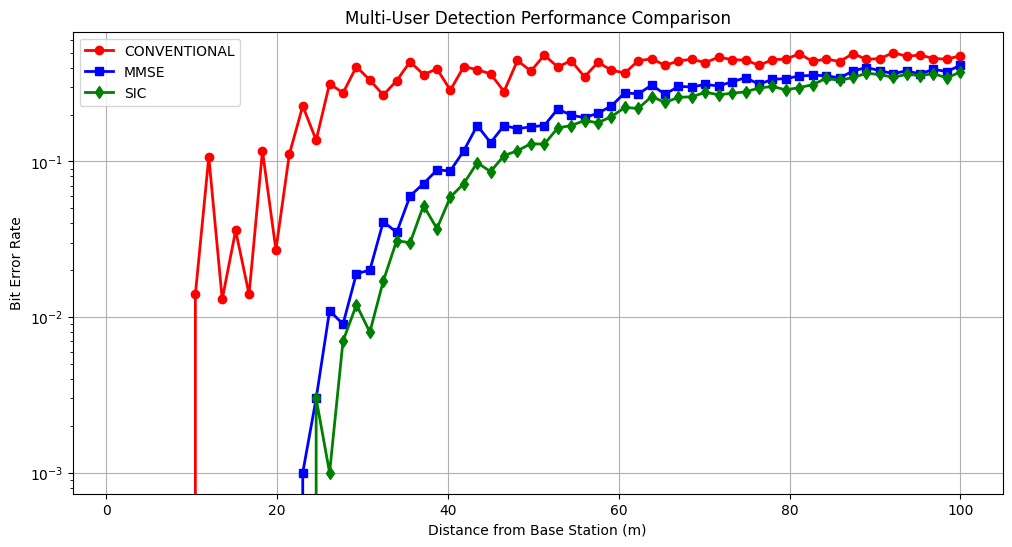

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv
from typing import List, Tuple
import seaborn as sns

class WirelessUser:
    def __init__(self, id: int, distance: float, spreading_code: np.ndarray, message: int):
        """
        Initialize a wireless user in the system.

        Args:
            id: User identifier
            distance: Distance from base station in meters
            spreading_code: User's unique spreading sequence
            message: Bit to transmit (0 or 1)
        """
        self.id = id
        self.distance = distance
        self.spreading_code = spreading_code
        self.message = message
        self.amplitude = self._calculate_amplitude()

    def _calculate_amplitude(self) -> float:
        """Calculate received signal amplitude using path loss model."""
        # Using simplified path loss model: A = 1/d^2
        return 1 / (self.distance ** 2)

    def get_signal(self) -> np.ndarray:
        """Generate user's transmitted signal."""
        return self.amplitude * self.spreading_code * (2 * self.message - 1)

class MUDSystem:
    def __init__(self, users: List[WirelessUser], noise_power: float = 0.1):
        """
        Initialize MUD system with multiple users.

        Args:
            users: List of WirelessUser objects
            noise_power: Noise variance (σ²)
        """
        self.users = users
        self.noise_power = noise_power
        self.spreading_length = len(users[0].spreading_code)

    def generate_received_signal(self) -> np.ndarray:
        """Generate composite received signal with noise."""
        total_signal = np.zeros(self.spreading_length)
        for user in self.users:
            total_signal += user.get_signal()

        noise = np.random.normal(0, np.sqrt(self.noise_power), self.spreading_length)
        return total_signal + noise

    def conventional_detector(self, received_signal: np.ndarray) -> List[int]:
        """Implement conventional correlation detector."""
        decisions = []
        for user in self.users:
            correlation = np.dot(received_signal, user.spreading_code)
            decisions.append(1 if correlation > 0 else 0)
        return decisions

    def mmse_detector(self, received_signal: np.ndarray) -> List[int]:
        """
        Implement MMSE detector with corrected matrix dimensions.

        The MMSE detector uses the following steps:
        1. Create spreading code matrix S
        2. Create amplitude matrix A
        3. Calculate correlation matrix R
        4. Calculate MMSE weight matrix W
        5. Apply weights to received signal
        """
        # Create spreading code matrix (N x K), where N is spreading length and K is number of users
        S = np.array([user.spreading_code for user in self.users]).T

        # Create amplitude matrix (K x K)
        A = np.diag([user.amplitude for user in self.users])

        # Calculate correlation matrix (N x N)
        R = S @ A @ S.T

        # Add noise to correlation matrix
        R_n = R + self.noise_power * np.eye(self.spreading_length)

        # Calculate MMSE weights (N x K)
        W = inv(R_n) @ S @ A

        # Apply weights to received signal (K x 1)
        y = W.T @ received_signal

        return [1 if yi > 0 else 0 for yi in y]

    def successive_ic(self, received_signal: np.ndarray) -> List[int]:
        """Implement Successive Interference Cancellation."""
        decisions = []
        remaining_signal = received_signal.copy()

        # Sort users by signal strength
        sorted_users = sorted(self.users, key=lambda x: x.amplitude, reverse=True)

        for user in sorted_users:
            correlation = np.dot(remaining_signal, user.spreading_code)
            bit_decision = 1 if correlation > 0 else 0
            decisions.append((user.id, bit_decision))

            reconstructed = user.amplitude * user.spreading_code * (2 * bit_decision - 1)
            remaining_signal -= reconstructed

        decisions.sort()
        return [d[1] for d in decisions]

def generate_random_spreading_codes(n_users: int, code_length: int) -> List[np.ndarray]:
    """
    Generate random binary spreading codes with minimum cross-correlation.

    Args:
        n_users: Number of users in the system
        code_length: Length of spreading codes

    Returns:
        List of spreading codes as numpy arrays
    """
    codes = []
    max_attempts = 1000
    attempts = 0

    while len(codes) < n_users and attempts < max_attempts:
        code = np.random.choice([-1, 1], code_length)
        # Check cross-correlation with existing codes
        if len(codes) == 0 or all(abs(np.correlate(code, existing)[0]) < code_length/2
                                 for existing in codes):
            codes.append(code)
        attempts += 1

    if len(codes) < n_users:
        raise ValueError(f"Could not generate {n_users} orthogonal codes. Try increasing code length.")

    return codes

def simulate_system(n_users: int = 8, code_length: int = 32, trials: int = 1000) -> dict:
    """
    Run multiple trials and collect performance statistics.

    Args:
        n_users: Number of users in the system
        code_length: Length of spreading codes
        trials: Number of simulation trials

    Returns:
        Dictionary containing error rates for each detection method
    """
    # System parameters
    distances = np.linspace(1, 10, n_users)
    spreading_codes = generate_random_spreading_codes(n_users, code_length)

    results = {
        'conventional': np.zeros(n_users),
        'mmse': np.zeros(n_users),
        'sic': np.zeros(n_users)
    }

    for _ in range(trials):
        messages = np.random.randint(0, 2, n_users)
        users = [WirelessUser(i, d, c, m) for i, (d, c, m) in
                enumerate(zip(distances, spreading_codes, messages))]

        system = MUDSystem(users)
        received_signal = system.generate_received_signal()

        conv_decisions = system.conventional_detector(received_signal)
        mmse_decisions = system.mmse_detector(received_signal)
        sic_decisions = system.successive_ic(received_signal)

        results['conventional'] += np.abs(conv_decisions - messages)
        results['mmse'] += np.abs(mmse_decisions - messages)
        results['sic'] += np.abs(sic_decisions - messages)

    # Convert to error rates
    for method in results:
        results[method] = results[method] / trials

    return results

def plot_results(results: dict, distances: np.ndarray):
    """Plot error rates vs distance for each detection method."""
    plt.figure(figsize=(12, 6))
    styles = {'conventional': 'ro-', 'mmse': 'bs-', 'sic': 'gd-'}

    for method, errors in results.items():
        plt.plot(distances, errors, styles[method], label=method.upper(), linewidth=2)

    plt.xlabel('Distance from Base Station (m)')
    plt.ylabel('Bit Error Rate')
    plt.title('Multi-User Detection Performance Comparison')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')  # Use log scale for better visualization
    return plt

# Run simulation with corrected parameters
np.random.seed(42)
n_users = 64
code_length = 128  # Increased from 16 to 32 for better separation
distances = np.linspace(1, 100, n_users)
results = simulate_system(n_users=n_users, code_length=code_length)

# Plot results
plt = plot_results(results, distances)
plt.show()